# Machine Learning for Renewable Energy Systems
<div style="text-align: right"> University of Tübingen, Summer Term 2023, Timothy Leske </div>

## Individual Assignment - Coding Track

### Building Electricity Demand

This code takes historic energy data for buildings and uses a linear regression model to forecast consumption for time horizons of one hour, one day and one week.

We begin by importing modules and functions required to carry out task. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from warnings import simplefilter

from sklearn.linear_model import Ridge

#### Data Pre-processing

Import raw utility meter data and combine into single .csv. The code used below was provided along with the original datasets. This section only needs to be used if the processed dataset has not yet been generated.

In [2]:
path_raw = "./data/meters/raw/" # path to the raw data
path_proc = "./data/meters/processed/" # path to the processed data (to be created)

files = glob(path_raw + "*.csv")

dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("/")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

complete_data.to_csv(path_proc + "allmeters.csv", index=False)

If the processed dataset is already available, it can be read in here and the previous step can be skipped. 

For the purpose of this assignment, the overall dataset is filtered to extract data just for the buildings where benchmarks were provided for comparison. Non-electricity data was discarded (for now), as its used was not found to improve performance of the currently used model.

In [3]:
# Read in data file (can be used if processed data file is already available)
complete_data = pd.read_csv("./data/meters/processed/allmeters.csv")

# Read in data from benchmark csv - used here to select only benchmarked buildings 
benchmark = pd.read_csv("benchmarks.csv")

# Create list of benchmark building names
benchmark_building_names = benchmark["name"].unique()

# Filter complete data for only benchmark buildings
benchmark_building_data = complete_data[complete_data["building_id"].isin(benchmark_building_names)]

# Only keep electricity data
benchmark_building_data = benchmark_building_data[benchmark_building_data["meter"] == "electricity"]

# Write to csv
benchmark_building_data.to_csv("benchmark_building_data.csv", index=False)

#### Feature Engineering

The function below is used to generate features for each time-step, based on the forecast horizon provided. In each case, a week of previous consumption is added as features for each timestep. The function chooses the offset for the previous consumption based on whether the horizon is daily, hourly or weekly. For example, if a weekly forecast horizon is chosen, hourly consumption for every hour between 2 weeks prior and 1 week prior to the current time will be added as features.

In addition, radial basis functions are added for the hour, month and day of week, to allow the model to identify cyclic trends in the dataset.

The feature engineering process results in NaN values at the start of the dataset, which are discarded. Interpolation is used to fill in actual missing electricity data values.

In [4]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

# Create function to perform feature engineering on the data

def feature_engineering(df, building, horizon = "hourly"):
    
    if horizon == "hourly":
        consumption_start = 1
    elif horizon == "daily":
        consumption_start = 24
    elif horizon == "weekly":
        consumption_start = 168
    else:
        print("Please enter a valid ForecastPeriod")

    consumption_end = consumption_start + 168

    # Create dataframe with data only for the selected building
    building_data = df[df["building_id"] == building]
    
    # Rename electricity column to y
    building_data = building_data.rename(columns={"meter_reading":"y"})

    # Add electricity features for each hour of the relevant period
    for i in range(consumption_start, consumption_end):
        building_data["y-" + str(i)] = building_data["y"].shift(i)

    # Create time features
    building_data["timestamp"] = pd.to_datetime(building_data["timestamp"])
    building_data["hour"] = building_data["timestamp"].dt.hour
    building_data["month"] = building_data["timestamp"].dt.month
    building_data["day_of_week"] = building_data["timestamp"].dt.dayofweek

    # Create radial basis function features for hour, month and day of week
    building_data["rbf_hour"] = np.exp(-(building_data["hour"] - 12)**2 / (2*4**2))
    building_data["rbf_month"] = np.exp(-(building_data["month"] - 6)**2 / (2*3**2))
    building_data["rbf_day_of_week"] = np.exp(-(building_data["day_of_week"] - 3)**2 / (2*2**2))

    # Drop rows of data equal to Consumption End as these will have NaN values for consumption features
    building_data = building_data[consumption_end:]

    # interpolate remaining NaN values
    building_data = building_data.interpolate()

    # Drop timestamp columns, as well as building_id
    building_data = building_data.drop(columns=["hour","day_of_week","month","building_id","meter"])

    return building_data

Data is split into test and train sets, with 2016 used for training and 2017 used for testing.

In [5]:
# Create function to split data into train and test and x and y sets, using 2016 as train set and 2017 as test set

def train_test_split(df):
    train = df[df["timestamp"].dt.year == 2016]
    test = df[df["timestamp"].dt.year == 2017]

    x_train = train.drop(columns=["timestamp","y"])
    y_train = train["y"]

    x_test = test.drop(columns=["timestamp","y"])
    y_test = np.asarray(test["y"])

    return x_train, y_train, x_test, y_test

#### Model Specification

THe function below allows for a choice of model. Later, a simple ridge linear regression algorithm is used.

In [6]:
# Create function to train and test model
def train_test_model(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

In [7]:
# Create function to plot predictions against actual values
def plot_predictions(y_pred, y_test):
    plt.figure(figsize=(20,10))
    plt.plot(y_pred, label="Predicted")
    plt.plot(y_test.values, label="Actual")
    plt.legend()
    plt.show()

In [8]:
# Create function to calculate RMSE and MAE
def calculate_errors(y_pred, y_test):
    rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    mae = np.mean(np.abs(y_pred - y_test))
    return rmse, mae

#### Forecasting

In the code below, energy consumption predictions are generated using the functions specified previously, along with a basic ridge linear regression model. This is performed for hourly, daily and weekly time horizons, and in each case RMSE and MAE are calculated. The predicted consumption values are saved into a dataframe for plotting purposes. The calculated errors are saved into a dataframe for evaluation against the provided benchmarks.

It is noted that several models were evaluated here, including gradient boosting and random forest regressors. These models were much slower than the linear regression, and were not found to perform better with the current feature set. There is obviously potential to use more sophisticated models to achieve better results, which will be investigated.

In [9]:
# Read in benchmark building data, if not generated above
#benchmark_building_data = pd.read_csv("benchmark_building_data.csv")

errors = []
predictions = []

# Iterate through benchmark buildings and perform feature engineering, train and test model, and calculate errors

for building in benchmark_building_names:
    for horizon in ("hourly", "daily", "weekly"):
        building_data = feature_engineering(benchmark_building_data, building, horizon)
        x_train, y_train, x_test, y_test = train_test_split(building_data)
        y_pred = train_test_model(Ridge(), x_train, y_train, x_test)
        # plot_predictions(building, y_pred, y_test)
        rmse, mae = calculate_errors(y_pred, y_test)
        
        predictions.append([building, horizon, y_pred, y_test])
        errors.append([building, horizon, rmse, mae])

errors = pd.DataFrame(errors, columns=["name", "horizon", "RMSE", "MAE"])
predictions = pd.DataFrame(predictions, columns=["name", "horizon", "predictions", "actuals"])

#### Evaluation against Benchmarks

The calculated errors for the forecasts are compared below to the provided benchmarks. In the majority of cases, the trained model achieves RMSE and MAE values similar to or better than the benchmark, however it appears to have performed more poorly for buildings where the benchmark RMSE or MAE was already high.

In [10]:
# Rename RMSE and MAE columns to distinguish from errors dataframe
benchmark = benchmark.rename(columns={"RMSE":"Benchmark RMSE", "MAE":"Benchmark MAE"})

# Merge benchmark and errors dataframes
evaluation = pd.merge(benchmark, errors, how="left", left_on=["name","horizon"], right_on=["name","horizon"])

# Calculate improvement in RMSE and MAE
evaluation["RMSE Improvement"] = evaluation["Benchmark RMSE"] - evaluation["RMSE"]
evaluation["MAE Improvement"] = evaluation["Benchmark MAE"] - evaluation["MAE"]

# Reorder columns
evaluation = evaluation[["name","horizon","Benchmark RMSE","RMSE","RMSE Improvement","Benchmark MAE","MAE","MAE Improvement"]]

evaluation

,name,horizon,Benchmark RMSE,RMSE,RMSE Improvement,Benchmark MAE,MAE,MAE Improvement
0,Bear_utility_Sidney,hourly,1.157131,0.811480,0.345651,0.846614,0.514739,0.331876
1,Bear_utility_Sidney,daily,1.255013,1.598653,-0.343640,0.862390,1.051345,-0.188954
2,Bear_utility_Sidney,weekly,1.851878,1.646001,0.205877,1.167219,1.161344,0.005875
3,Cockatoo_religion_Diedre,hourly,1.475301,1.345530,0.129772,1.018945,0.912596,0.106349
4,Cockatoo_religion_Diedre,daily,2.349360,2.168196,0.181164,1.820794,1.692118,0.128676
5,Cockatoo_religion_Diedre,weekly,2.833513,2.387464,0.446049,1.958076,1.960720,-0.002645
6,Cockatoo_science_Rex,hourly,7.304536,7.341011,-0.036474,5.529282,5.167725,0.361557
7,Cockatoo_science_Rex,daily,10.882962,13.055890,-2.172928,7.975783,9.035369,-1.059586
8,Cockatoo_science_Rex,weekly,12.667458,16.530806,-3.863348,8.261340,11.923341,-3.662001
9,Eagle_education_Teresa,hourly,8.286079,8.448045,-0.161966,5.855556,5.406154,0.449402


#### Visualisation

Predicted and actual consumption values were plotted for the first two weeks of the test set period to identify obvious model shortcomings:
- There is what possibly looks like a one day lag between the actual and predicted values in the daily model, suggesting that the model is basing predictions too heavily on the previous day of data, and not accounting sufficiently for weekly cycling variation.
- There appear to be some meter failures during the test period, already visible in the first two weeks (notably for Hog_office_Bill and Lamb_assembly_Bertie). Regardless of our model, we will not be able to predict these failures in advance, so the RMSE will inevitably be high for buildings where frequent failures occur. Meter failures during the training period may be affecting model training.

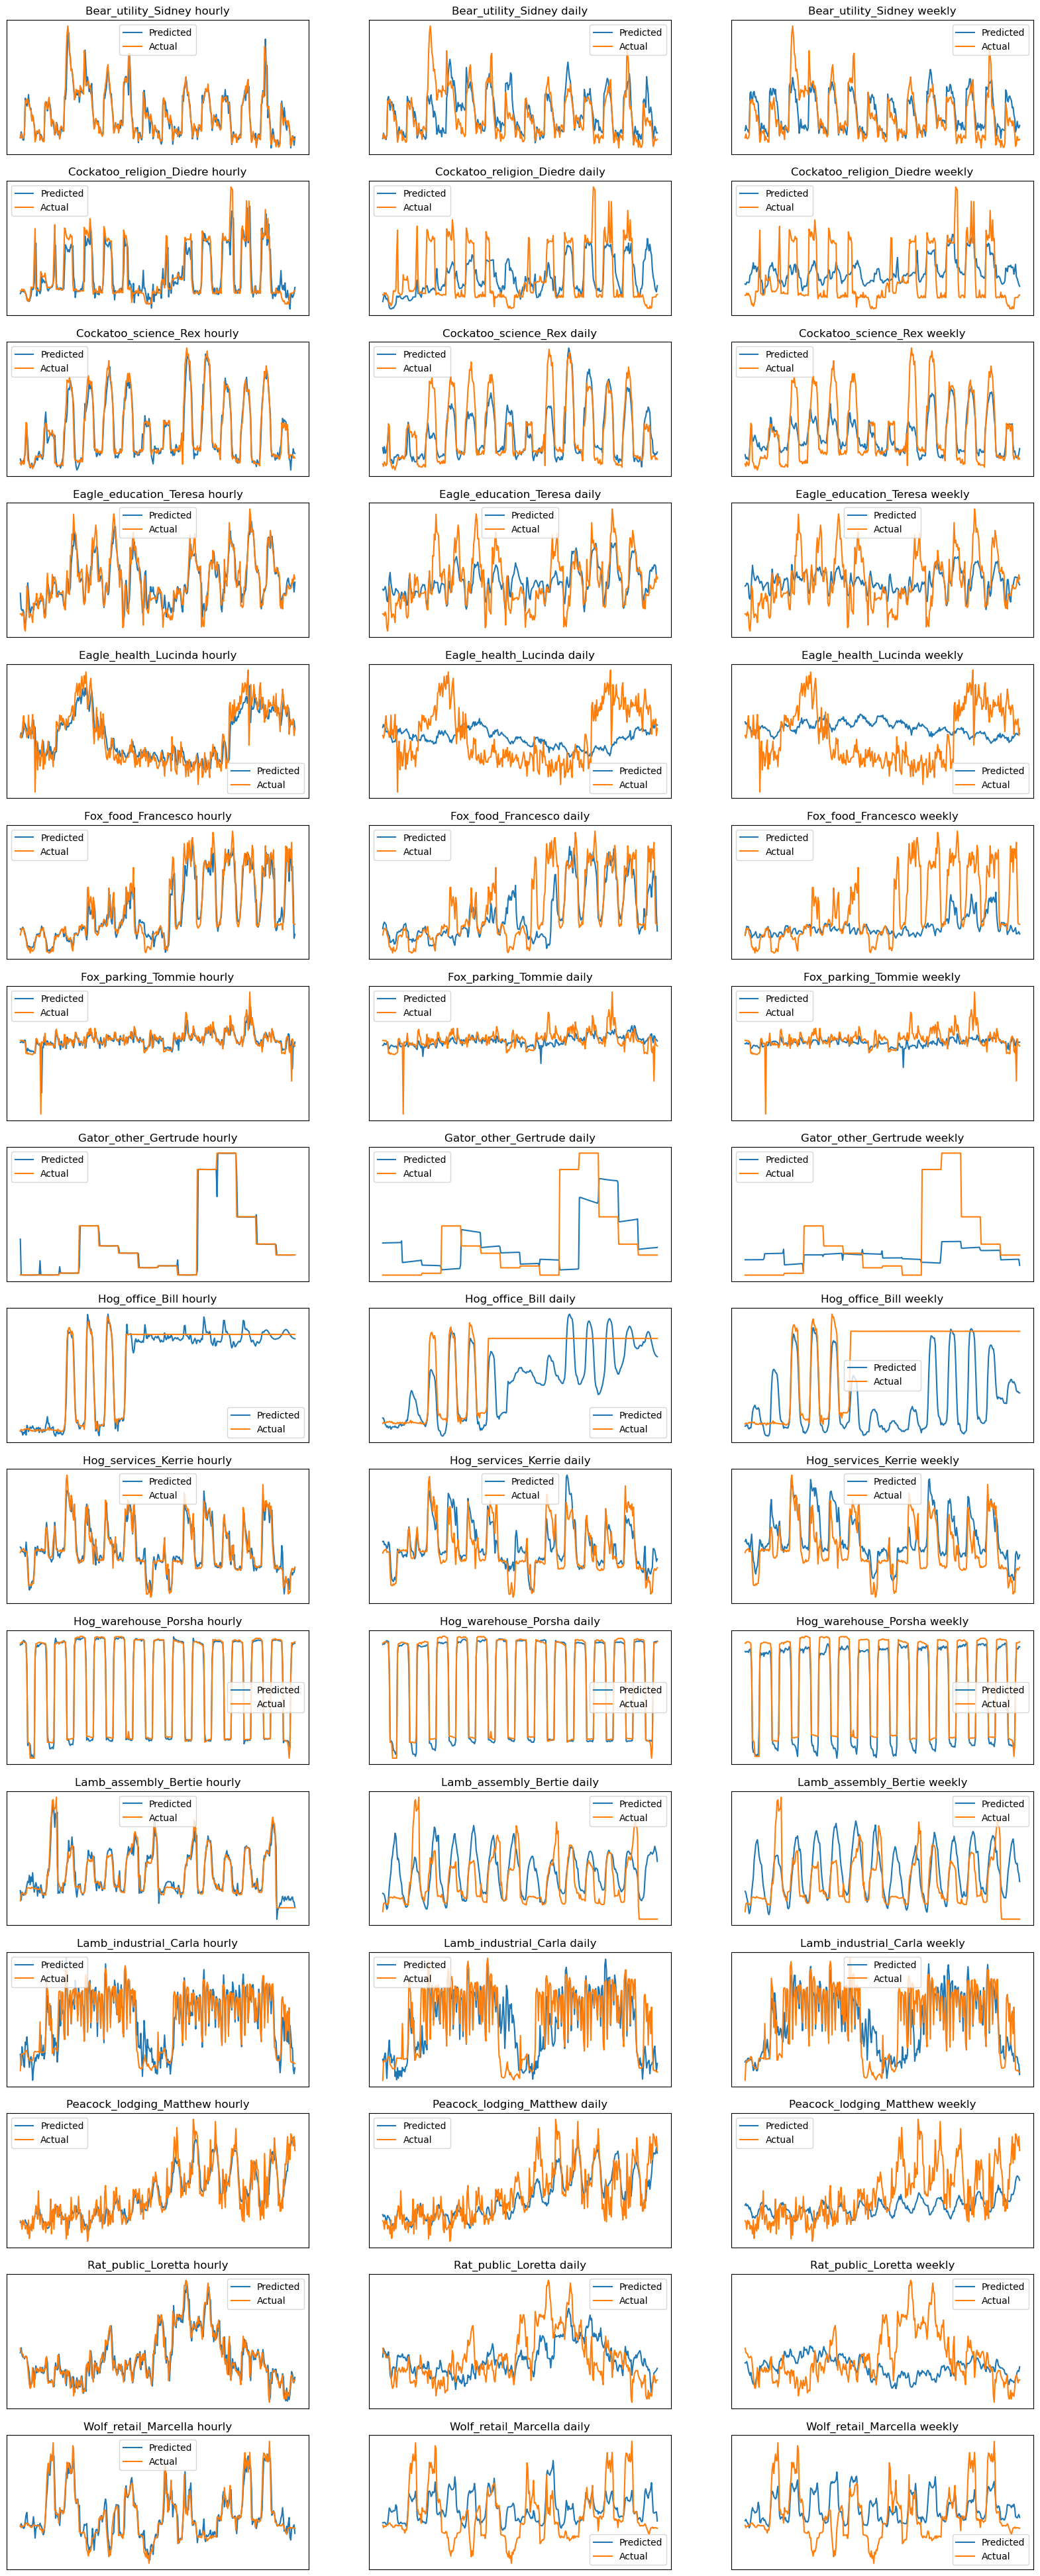

In [11]:
fig, axes = plt.subplots(len(benchmark_building_names), 3, figsize=(20,50))

for i, ax in enumerate(axes.flatten()):
    ax.plot(predictions["predictions"][i][:336])
    ax.plot(predictions["actuals"][i][:336])
    ax.set_title(predictions["name"][i] + " " + predictions["horizon"][i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(["Predicted", "Actual"])

#### Extension Ideas

- Account for daylight savings in datasets
- Use meter data for other utility meters as additional features
- Use data for other buildings in the same category
- Use more advanced machine learning algorithms
- Use past weather data and weather forecasts
- Identify meter failures in training data and make sure this data is not used for training?